# Hands-on Day 2

## You'll learn

### ML methods

- Multilayer Perceptron Classifier (MCP) with pyspark.ml

### ML techniques
- hyperparameter optimisation
- ROC curves

In [1]:
#initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

# initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [2]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-leggerf>

# Data preprocessing

In [3]:
#inputFile = 'file:///home/jovyan/Higgs100k.parquet'
#inputFile = 'file:///home/jovyan/Higgs1M.parquet'
inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 12 ms, sys: 2.93 ms, total: 14.9 ms
Wall time: 4.87 s
There are 10000000 events


In [4]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 8002097
Events for validation 1997903


In [5]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

# ML models: MCP

## Exercise 1

- Implement a shallow NN: use *MultiLayerPerceptronClassifier* from pyspark
- documentation: https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
- implement a network with: 
  - one input layer of size 28 (our features), 
  - two intermediate layers of size 30,
  - one output of size 2 (the label classes)
  - other hyerparameters: maxIter=100, blockSize=128, seed=1234
- plot the various metrics (ROC, signal vs background)
- bonus: do hyperparameter optimisation

In [6]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:

# input layer of size 28 (features), two intermediate of size 30, and output of size 2 (classes)
layers = [28, 30, 30, 2]

# create the trainer and set its parameters
mpc = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)

In [7]:
%%time
model_mpc = mpc.fit(train)

CPU times: user 4.06 s, sys: 1.04 s, total: 5.1 s
Wall time: 7min 13s


Test set AUC = 0.7296364254106741


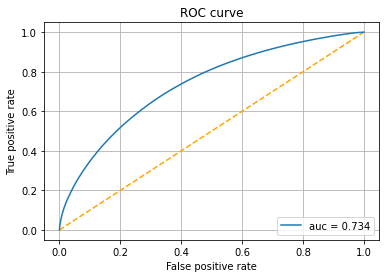

In [8]:
# compute accuracy on the test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = model_mpc.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

#make ROC curve
drawROC(result)

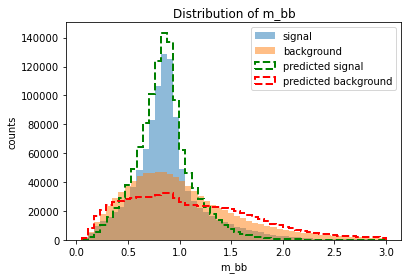

In [9]:
#plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, 'm_bb')

In [10]:
#when you're done, stop spark, this will release the resources you're using
spark.stop()